# Load Data and Processing

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import cv2
import random
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
DATA_DIR = '../input/large-gender-face-dataset/big_face_gender_data'
print(os.listdir(path=DATA_DIR))

['Validation', 'Test', 'Train']


In [7]:
# Use ImageDataGenerator to process input data, attach labels, and prevent overflow ram during training

batch_size = 512
image_shape = (218,178)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range=0.2,
                                   zoom_range = [0.8, 1.2], horizontal_flip=True,
                                   brightness_range= [0.7, 1.3],width_shift_range=0.2,
                                   height_shift_range=0.2, fill_mode='nearest',
                                   preprocessing_function=add_noise) #preprocessing_function=add_noise

train = train_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Train',
                                       target_size=image_shape, batch_size=batch_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Validation',
                                          target_size=image_shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 181665 images belonging to 2 classes.
Found 17765 images belonging to 2 classes.


In [29]:
img, label = train.next()
print(img[1].shape)

(218, 178, 3)


In [18]:
print('Len(train):',len(train))
print('len(val):', len(val))

Len(train): 5678
len(val): 556


In [5]:
print(train.class_indices)
train.classes

{'Female': 0, 'Male': 1}


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

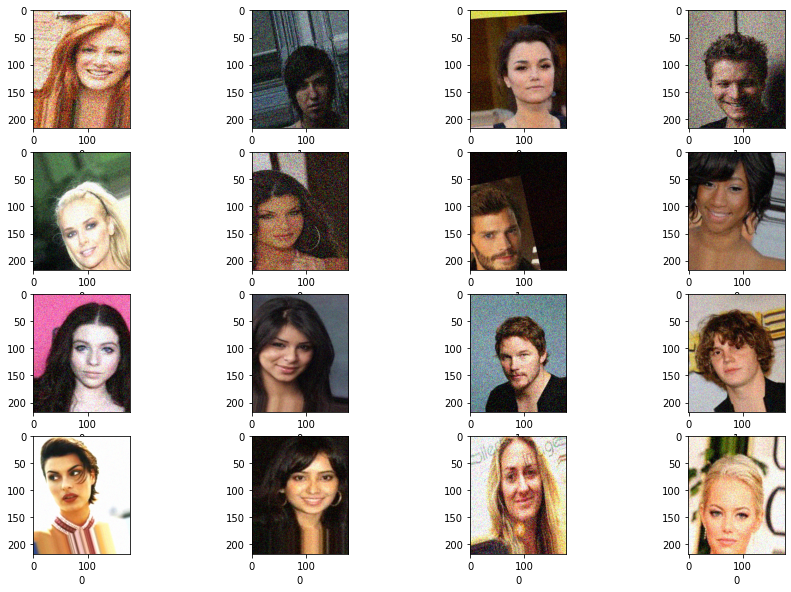

In [8]:
# Show image
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# Build Model VGG 16

![](http://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

In [11]:
input_shape = (218, 178, 3)
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for i,layer in enumerate(pre_trained_model.layers):
    print(i,layer.name)
print("\nInput:", pre_trained_model.input)
print("Output:", pre_trained_model.output)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool

Input: KerasTensor(type_spec=TensorSpec(shape=(None, 218, 178, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Output: KerasTensor(type_spec=TensorSpec(shape=(None, 6, 5, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


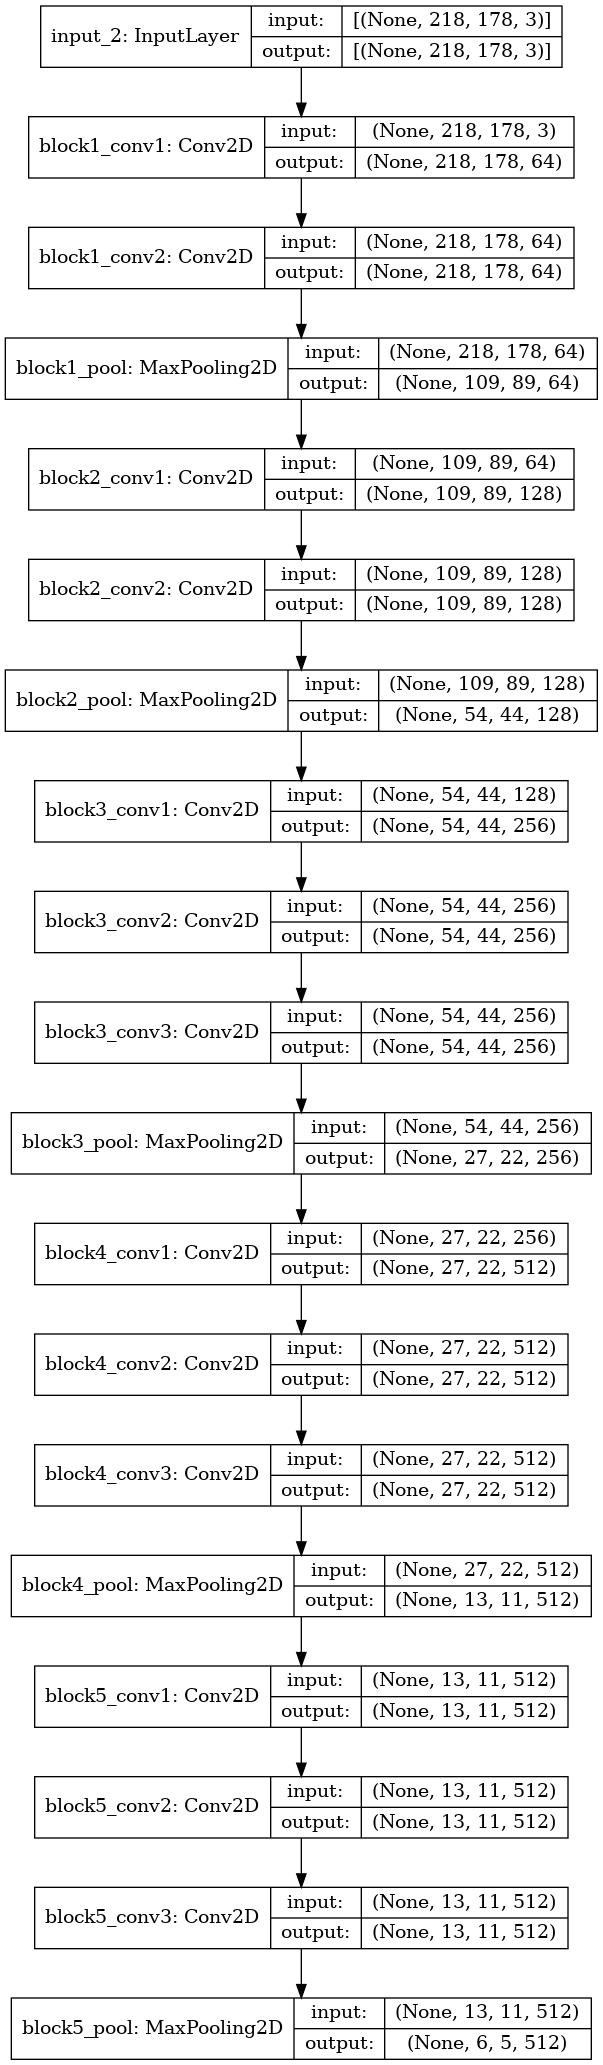

In [12]:
# Visualation VGG 16 architecture
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Fine Turning Parameters by Grid Search

In [3]:
# Set data for fine tuning
X_f = []
y_f = []
for i in range(200):
    img, label = next(train)
    X_f.append(img)
    y_f.append(label)
X_fine_tuning = np.concatenate(X_f)
y_fine_tuning = np.concatenate(y_f)
print('The number of data:',len(X_fine_tuning))

The number of data: 6400


In [ ]:
def define_model(learning_rate=0.0001, optimizer='Adam'):
    input_shape = (218, 178, 3)
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet") #classes=1 
    for layer in pre_trained_model.layers[:15]:
        layer.trainable = False
    for layer in pre_trained_model.layers[15:]:
        layer.trainable = True
    last_layer = pre_trained_model.get_layer('block5_pool')
    last_output = last_layer.output
    x = GlobalMaxPooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

# Set parameters default
epochs=10
batch_size=32

model = KerasClassifier(build_fn=define_model, epochs=epochs,
                        batch_size=batch_size, verbose=1)

# List Parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam', 'Ftrl']
learning_rate = [0.001, 0.01, 0.1]

param_grid = dict(optimizer=optimizer, learning_rate=learning_rate)

checkpoint_f = ModelCheckpoint('model_fine_tuning.h5', verbose=1, mode='auto',
                               monitor='val_accuracy', save_best_only=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3) #Máy mạnh thì n_jobs = -1
grid_result = grid.fit(X_fine_tuning, y_fine_tuning, callbacks=[checkpoint_f], validation_split=0.2)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best: 0.824176 using {learning_rate': 0.001, 'optimizer': 'Adagrad'}

In [ ]:
# Tune Learning Rate and Momentum

# #NOTE: Add default optimizer, otherwise throws error 'optimizer not legal parameter'
# def define_model(learning_rate=0.01, momentum=0.7):
#     input_shape = (218, 178, 3)
#     pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet", classes=1) 
#     #False khi bức hình truyền vào không phải 224x224x3
    
#     for layer in pre_trained_model.layers[:15]:
#         layer.trainable = False

#     for layer in pre_trained_model.layers[15:]:
#         layer.trainable = True
    
#     last_layer = pre_trained_model.get_layer('block5_pool')
#     last_output = last_layer.output
    
#     # Flatten the output layer to 1 dimension
#     x = GlobalMaxPooling2D()(last_output)
#     # Add a fully connected layer with 512 hidden units and ReLU activation
#     x = Dense(512, activation='relu')(x)
#     # x = Dense(512, activation='relu')(x)
#     # Add a dropout rate of 0.5
#     x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
#     # Add a final sigmoid layer for classification
#     x = Dense(1, activation='sigmoid')(x)

#     model = Model(pre_trained_model.input, x)

#     optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum)
#     model.compile(loss='binary_crossentropy',optimizer=optimizer,
#                   metrics=['accuracy'])
#     return model

# model = KerasClassifier(build_fn=define_model, 
#                         epochs=epochs, 
#                         batch_size = batch_size, 
#                         verbose=0)

# learning_rate = [0.0001, 0.001, 0.01, 0.1]
# momentum = [0.3, 0.5, 0.7, 0.9]

# param_grid = dict(learning_rate=learning_rate, momentum=momentum)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
# grid_result = grid.fit(X,y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))
    
#  # Best lr =0.01, momentum=0,7

# Train Model

In [4]:
input_shape = (218, 178, 3)

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

#Use VGG16's 15 layers for Feature Extraction
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Dropout layer to reduce overfitting
x = Dropout(0.5)(x)  
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)
    
model.compile(keras.optimizers.Adagrad(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Best: 0.824176 using {'learning_rate': 0.001, 'optimizer': 'Adagrad'}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 218, 178, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 218, 178, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 218, 178, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 109, 89, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 109, 89, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 109, 89, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 44, 128)       0   

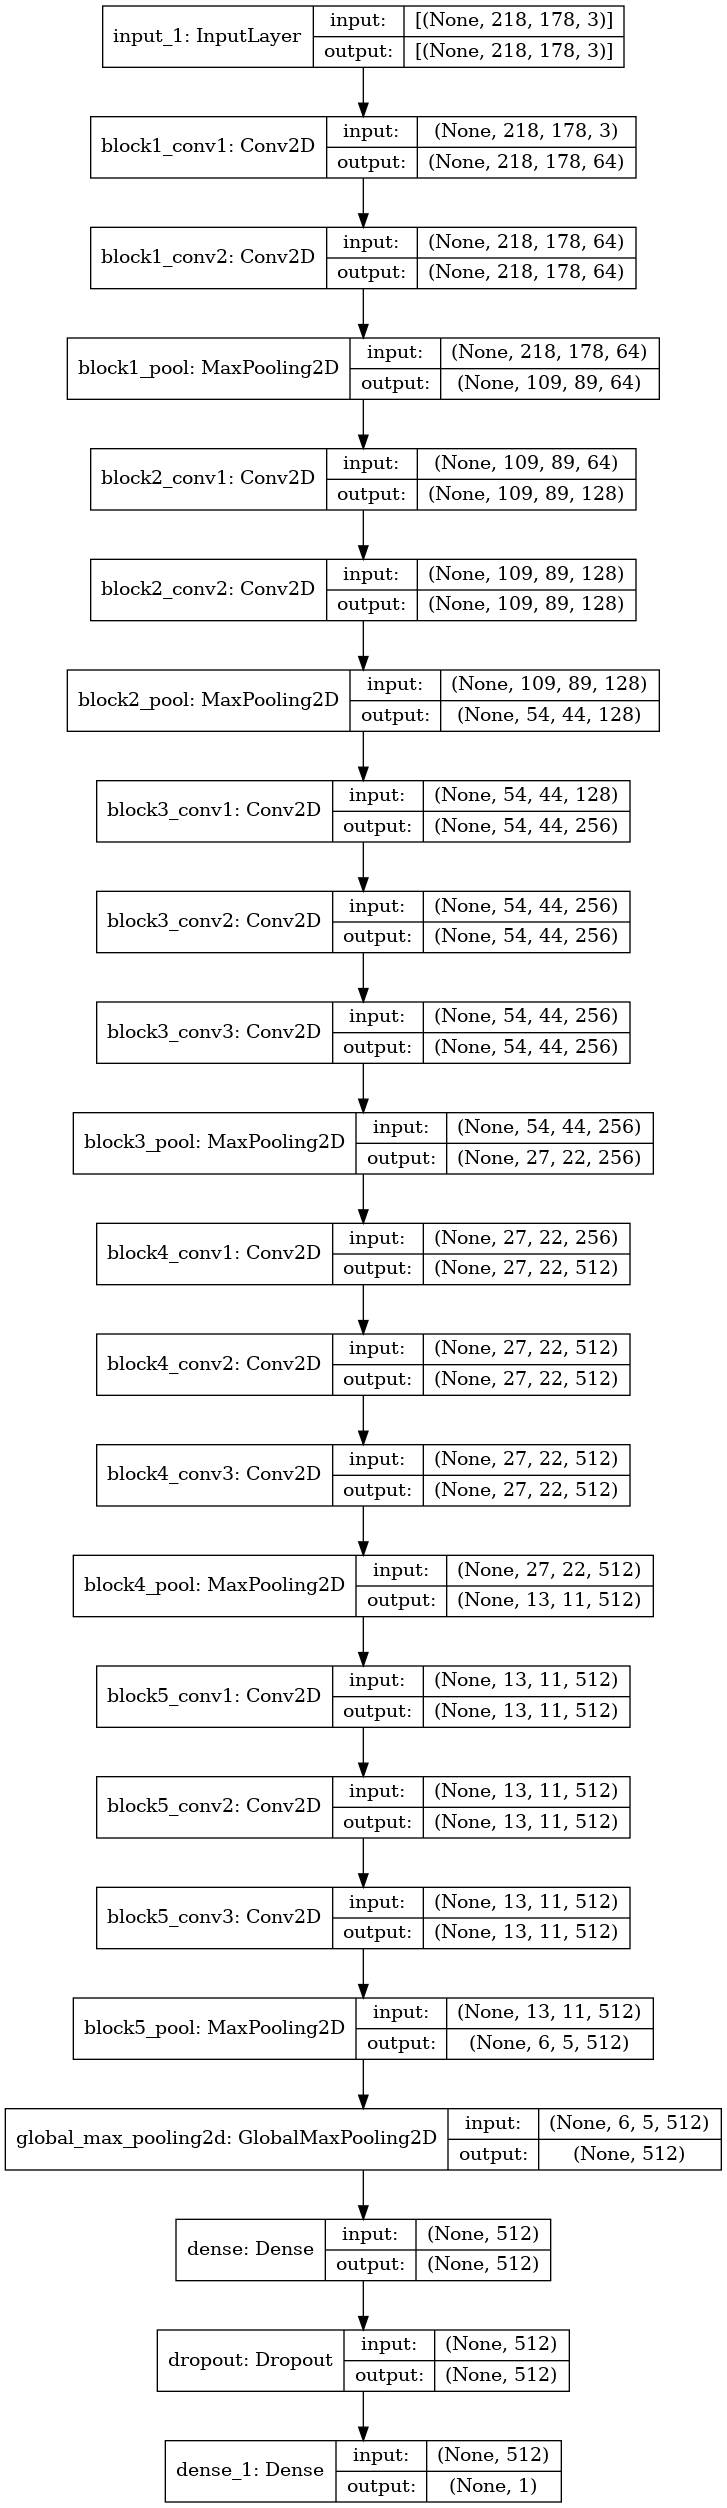

In [3]:
# Visualation VGG 16 architecture
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [6]:
# Train Model with fine tuning parameters
# Best: 0.824176 using {learning_rate': 0.001, 'optimizer': 'Adagrad'}

checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train, epochs=20,
    validation_data=val,
    verbose=1, callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-23 19:18:34.052982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-23 19:18:39.933384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-10-23 19:18:44.172012: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


 45/355 [==>...........................] - ETA: 23:36 - loss: 0.0458 - accuracy: 0.9856

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


355/355 [==============================] - 1965s 5s/step - loss: 0.0439 - accuracy: 0.9861 - val_loss: 0.0695 - val_accuracy: 0.9747

Epoch 00001: val_accuracy improved from -inf to 0.97467, saving model to training_save.h5
Epoch 2/20
355/355 [==============================] - 811s 2s/step - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.0688 - val_accuracy: 0.9747

Epoch 00002: val_accuracy improved from 0.97467 to 0.97473, saving model to training_save.h5
Epoch 3/20
355/355 [==============================] - 786s 2s/step - loss: 0.0432 - accuracy: 0.9861 - val_loss: 0.0687 - val_accuracy: 0.9748

Epoch 00003: val_accuracy improved from 0.97473 to 0.97478, saving model to training_save.h5
Epoch 4/20
355/355 [==============================] - 788s 2s/step - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0691 - val_accuracy: 0.9747

Epoch 00004: val_accuracy did not improve from 0.97478
Epoch 5/20
355/355 [==============================] - 761s 2s/step - loss: 0.0424 - accuracy: 0.9863 - 

In [ ]:
np.save('vgg_history.npy',history.history)

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


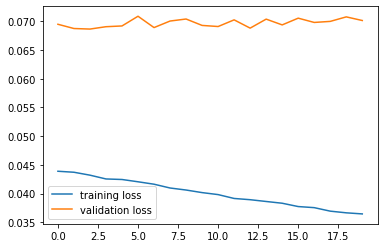

In [7]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

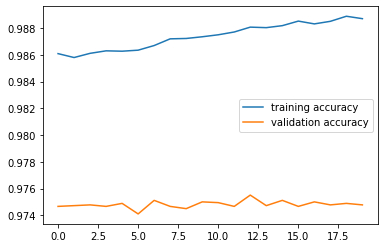

In [8]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


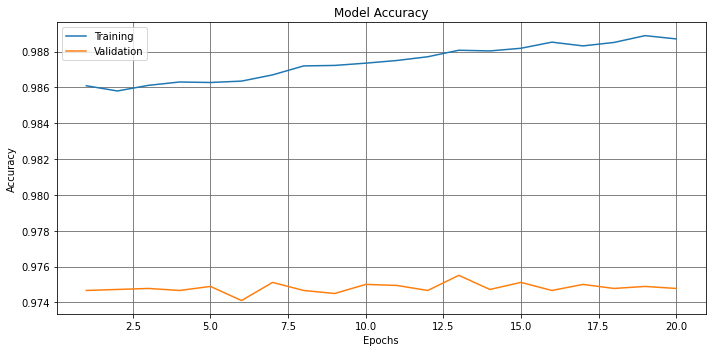

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


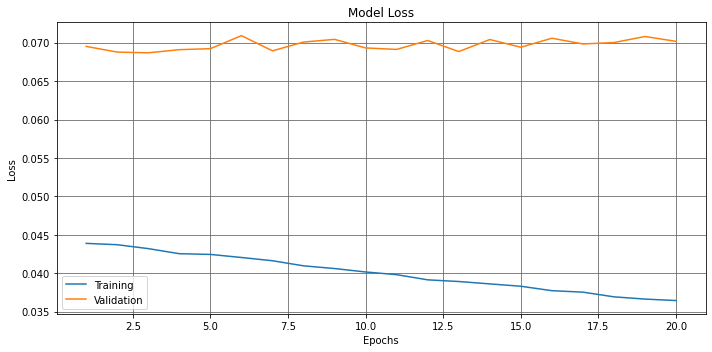

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [58]:
history1 = np.load('../input/my-data/vgg_history_20e.npy',allow_pickle='TRUE').item()
history2 = np.load('../input/my-data/vgg_history_20e_2.npy',allow_pickle='TRUE').item()
history3=np.load('../input/my-data/vgg_history_20e_3.npy',allow_pickle='TRUE').item()

loss = []
accuracy = []
val_loss = []
val_accuracy = []
for i in range(20):
    loss.append(history1.get('loss')[i])
    accuracy.append(history1.get('accuracy')[i])
    val_loss.append(history1.get('val_loss')[i])
    val_accuracy.append(history1.get('val_accuracy')[i])
for i in range(20):
    loss.append(history2.get('loss')[i])
    accuracy.append(history2.get('accuracy')[i])
    val_loss.append(history2.get('val_loss')[i])
    val_accuracy.append(history2.get('val_accuracy')[i])
for i in range(20):
    loss.append(history3.get('loss')[i])
    accuracy.append(history3.get('accuracy')[i])
    val_loss.append(history3.get('val_loss')[i])
    val_accuracy.append(history3.get('val_accuracy')[i])
    
loss = np.array(loss)
accuracy = np.array(accuracy)
val_loss = np.array(val_loss)
val_accuracy = np.array(val_accuracy)


In [61]:
df = pd.DataFrame({'loss': loss, 'accuracy': accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})
df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.216986,0.912768,0.159593,0.939037
1,0.173346,0.931583,0.144490,0.943541
2,0.151403,0.941199,0.121008,0.954011
3,0.138153,0.946368,0.125693,0.953560
4,0.127003,0.951080,0.107251,0.959527


In [62]:
history = df.to_dict('list')
print(type(history))


<class 'dict'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


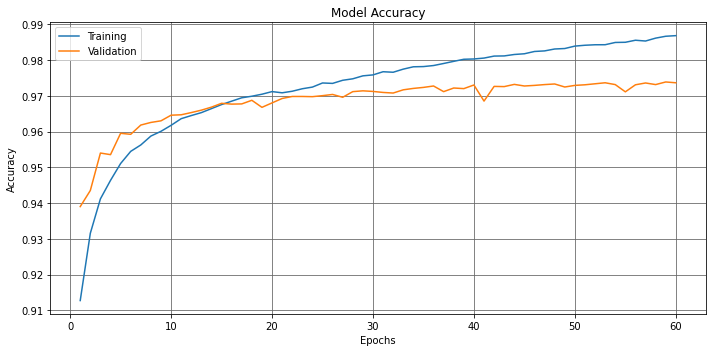

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


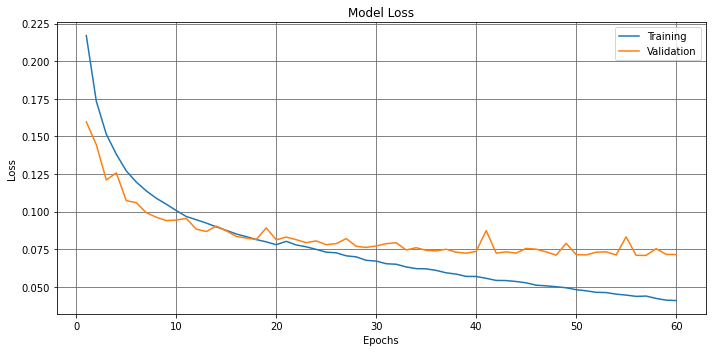

In [63]:
epochs = len(history.get('accuracy'))

acc = history.get('accuracy')
val_acc = history.get('val_accuracy')
loss = history.get('loss')
val_loss = history.get('val_loss')

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

# Evaluation on test set

In [2]:
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Test',
                                          target_size=(218,178), batch_size=32,
                                          class_mode='binary', color_mode='rgb', shuffle=False)

Found 16779 images belonging to 2 classes.


In [6]:
predictions = []
labels = []
for i in range(len(test)):
    x, y = next(test)
    pre = model.predict(x)
    pre = [1 if x > 0.5 else 0 for x in pre]
    predictions.append(pre)
    labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
print(len(predictions))

2022-11-03 08:32:45.986745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-03 08:32:47.113624: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


16779


              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8320
         1.0       0.98      0.98      0.98      8459

    accuracy                           0.98     16779
   macro avg       0.98      0.98      0.98     16779
weighted avg       0.98      0.98      0.98     16779

Confusion matrix, without normalization
[[8172  148]
 [ 168 8291]]


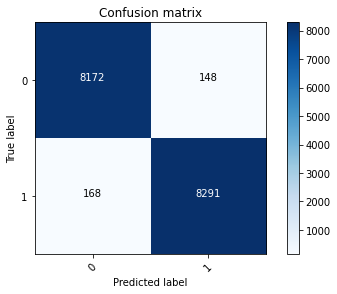

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
#--------------------------------------------------------------------------------------------------
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(labels, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(labels, predictions, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(labels, predictions, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, predictions, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(labels, predictions, multi_class='ovr')
print('ROC AUC: %f' % auc)

Accuracy: 0.981167
Precision: 0.981159
Recall: 0.981176
F1 score: 0.981166
ROC AUC: 0.981176


### Discover the wrong prediction photo

In [14]:
arr_error = []
for i in range(int(len(labels))):
    if labels[i] != predictions[i]:
        arr_error.append(i)
len("Tổng các bức ảnh dự đoán sai: ", arr_error)

307

In [15]:
imgs = []
for i in range(len(test)):
    x, y = next(test)
    if i in arr_error:
        imgs.append(x)
imgs = np.concatenate(imgs)
print(len(imgs))

288


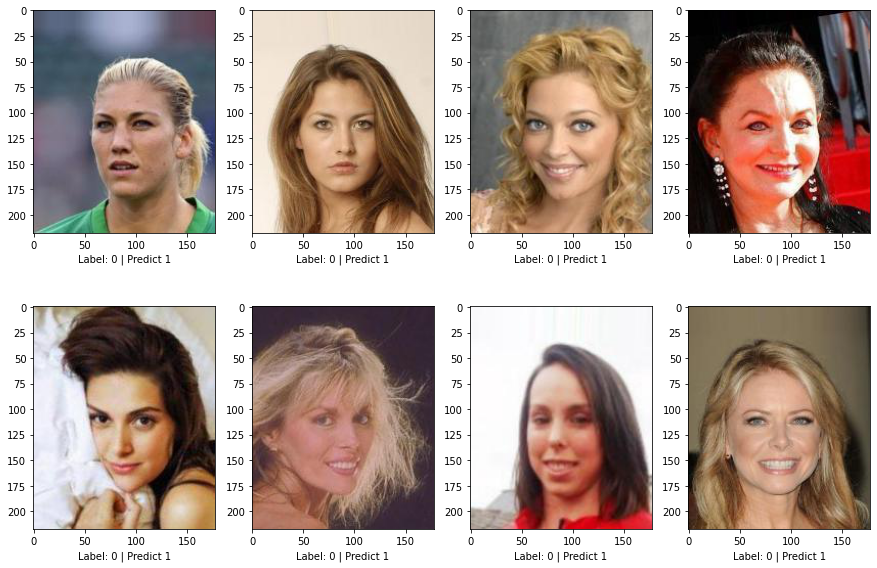

In [16]:
fig = plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(2,4,i)
    plt.imshow(imgs[i])
    plt.xlabel( f"Label: {int(labels[arr_error[i]])} | Predict {int(predictions[arr_error[i]])}")
plt.show()

In [ ]:
# Saving model
model.save('vgg16_finish.h5')
print('Done! Model Saved!')

In [ ]:
# Load model
from tensorflow import keras
model = keras.models.load_model('../input/my-data/final.h5')

# Test Actual Data

Shape of resize: (218, 178, 3)


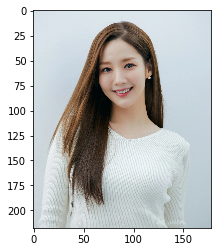

Probability: 0
===> GENDER:  Female


In [57]:
image = cv2.imread('../input/my-data/park-min-young.jpg')
r_size = cv2.resize(image,(178,218))
print("Shape of resize:", r_size.shape)
roi = cv2.cvtColor(r_size, cv2.COLOR_BGR2RGB)
from matplotlib import pyplot as plt
plt.imshow(roi, interpolation='nearest')
plt.show()
finish = roi.reshape(1,218,178,3)

y_pre = model.predict(finish)
print("Probability:", int(y_pre))
x = str('Male' if y_pre > 0.5 else 'Female')
print("===> GENDER: ", x)

### Detect and Crop Face

Shap of image: width=720, height=1280, depth=3
Shape of resize: (218, 178, 3)


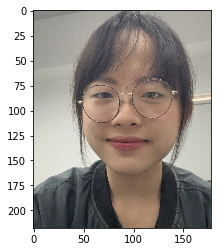

Shape of image: (1, 218, 178, 3)
Probability: 0.0
===> GENDER:  Female


In [47]:
image = cv2.imread('../input/my-data/nu.jpg')
(h, w, d) = image.shape
print("Shap of image: width={}, height={}, depth={}".format(w, h, d))

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(image, 1.2, 10, minSize=(100,100))
    
for (x, y, w, h) in faces:
    y=y-200
    if y<0: y=0
    x=x-200
    if x<0: x=0
    w=w+418
    h=h+494  # +18% of w
    crop = image[y:y+h,x:x+w]
    print("Shape of crop:", crop.shape)

r_size = cv2.resize(crop,(178,218))
print("Shape of resize:", r_size.shape)
roi = cv2.cvtColor(r_size, cv2.COLOR_BGR2RGB)
from matplotlib import pyplot as plt
plt.imshow(roi, interpolation='nearest')
plt.show()

finish = roi.reshape(1,218,178,3)
print("Shape of image:", finish.shape)


y_pre = model.predict(finish)
print("Probability:", float(y_pre))
x = str('Male' if y_pre > 0.5 else 'Female')
print("===> GENDER: ", x)